# Brightnes profiles for the deconvolved data and initial polarimetric images

- radial profiles and check for the order of PSF smearing correction and deconvolution
- test for the possibility of calculation scattered light persentage from total intensity image

This scipt is adjusted to ZIMPOL data, but with slight modification can be used for IRDIS as well


## Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh,cameras):
    #min and max values setted manually here to 0 and 1
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key]) 
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout
       
    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].min() for key in keys)
    vmax =max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].max() for key in keys)

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6
            lim=lim1*12.27/3.6
            
        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, -d, d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        levels=[np.max(data_arcshin[key])/4,np.max(data_arcshin[key])/2]
        CS=ax.contour(data_arcshin[key], levels=levels,colors=['pink','white'], extent=(-d, d, -d, d))
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_title(labels[key])
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    #specific_folder=figfolder+'models/'
    #try:
    # Create target Directory
    #   os.mkdir(specific_folder)
    #except FileExistsError:
    #    print("Directory " , specific_folder,  " already exists")
   
    #plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    


def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

def LoadImage_dec (dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            ps =3.6
            n=image.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        




def load_I(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
            i=(iq+iu)/2
            
    return iq,iu,i


   
def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n


def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout
    
def Loadimages_notdeconv(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimages(dirdat,band, extension):
    dir = dirdat
    qfile = band+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]
                
    return image, n



## Set up

In [2]:
stars=['AR_Pup_dc_notnorm','HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','UMon_Katya','UMon']
ref_of_sci={'AR_Pup_dc_notnorm':'HD75885','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals
disk_incl_pa={'AR_Pup_dc_notnorm':[75,45],'UMon':[25,144],'UMon_Katya':[25,144],'V709_Car':[34,13],'HR4049_20190108':[49,63],'HR4049_20190107':[49,63],"HR4049_combined":[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle

star = stars[4]

incl_pa=disk_incl_pa[star]
fittypes=['1', '2']

band=['V','I']
ps=3.6
dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'
dirdat = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Deconvolution_corr_tel+unres/'+star+'/'  

figfolder=dirdat0+'After_deconv/'
createfolder(figfolder)
figfolder=figfolder+star+'/'
createfolder(figfolder)
normlim=45


## Comparing the PSF smearing correction before and after deconvolution

PSF is from reference star


V
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ_phi/I[%] sumPI/I[%] 
deconvolved                    334.942    24.658      40.236     0.295      0.397       
deconvolved+smearing           334.942    96.709      102.601    0.810      1.086       


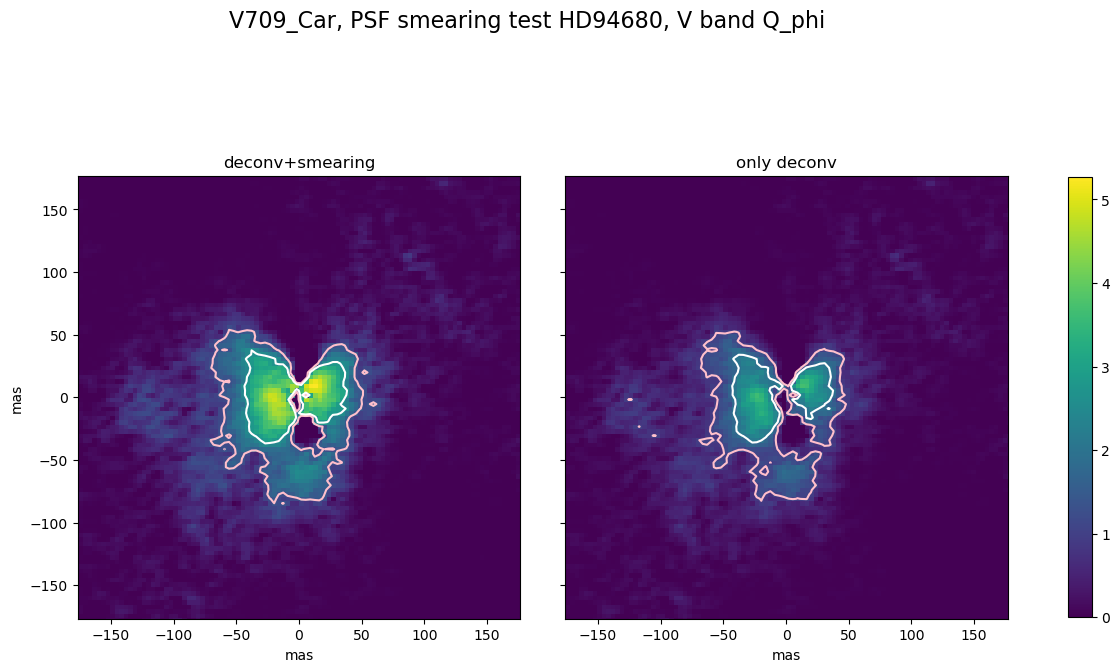

I
reference                      max_DoLP[%] max_Q_phi  max_PI     sumQ_phi/I[%] sumPI/I[%] 
deconvolved                    7.314      141.061     135.940    0.239      0.297       
deconvolved+smearing           7.314      329.059     375.520    0.473      0.632       


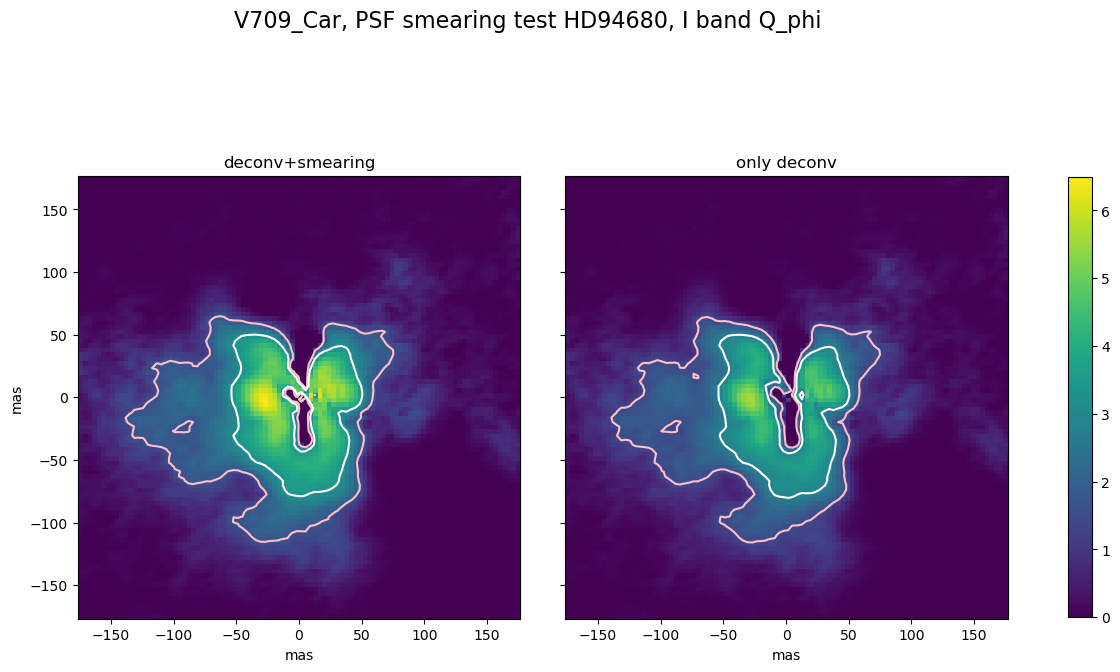

In [3]:


for fittype in fittypes:
    print(band[int(fittype)-1])
    output_filename = dirdat+star+'_'+band[int(fittype)-1]+'after_allcorr_stats.txt'
    with open(output_filename, 'w') as file_print:
        line="{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} ".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ_phi/I[%]","sumPI/I[%]")
        #"{:<30} {:<10} {:<10} {:<10} {:<15}{:<10} {:<10} {:<10} {:<10}  \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", 'Peak_I(Strehl)','Peak_PI','Peak_Qphi', "sumQ_phi/I[%]","sumPI/I[%]")

        print(line)
        file_print.write(line) 

        dir =dirdat +'/deconvolved_'+'Q_phi'+'/' 
        Q_phi_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        dir =dirdat +'/deconvolved_'+'PI'+'/'
        PI_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])

        I=LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/',star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
        #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])  
    
        
        frac =np.max(np.divide(Q_phi_decon,I,where=I!=0)*(R<=150))*100
        mask=(R<=normlim)
        qphi_sum=np.sum(Q_phi_decon[mask])
        I_sum=np.sum(I[R<=1500/ps])
        pi_sum=np.sum(PI_decon[mask])

        
        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f}  ".format('deconvolved',
            frac, np.max(Q_phi_decon), np.max(PI_decon), qphi_sum/I_sum*100, pi_sum/I_sum*100)
        print(line)
        file_print.write(line) 
        
        
        if star!='AR_Pup_dc_notnorm':
            f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
            f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
        elif star=='AR_Pup_dc_notnorm':
            f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_qphi_circular_f_psf_50.fits')
            f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_pi_circular_f_psf_50.fits')

       
        Q_phi_decon_smear=Q_phi_decon*f_q
        PI_decon_smear=PI_decon*f_pi


       
        frac =np.max(np.divide(Q_phi_decon_smear,I,where=I!=0)*(R<=150))*100
        mask=(R<=normlim)
        qphi_sum=np.sum(Q_phi_decon_smear[mask])
        pi_sum=np.sum(PI_decon_smear[mask])

        line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f}  ".format('deconvolved+smearing',
            frac, np.max(Q_phi_decon_smear), np.max(PI_decon_smear), qphi_sum/I_sum*100, pi_sum/I_sum*100)
        print(line)
        file_print.write(line) 
    
        
        keys=['deconv+smearing','deconv']
        labels={'deconv+smearing':'deconv+smearing','deconv':'only deconv'}
        data={'deconv+smearing': Q_phi_decon_smear ,'deconv':Q_phi_decon}
        cameras=['ZIMPOL','ZIMPOL']
        plot_with_same_color(data, keys, labels ,'Q_phi',star+', PSF smearing test '+ref_of_sci[star]+', '+band[int(fittype)-1]+ ' band',4*ps,True,cameras)
        plt.savefig(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        out_fits = fits.HDUList(fits.PrimaryHDU(Q_phi_decon_smear))                  # create output fits structure
        out_fits.writeto(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.fits', overwrite = True)                       # write output
        out_fits = fits.HDUList(fits.PrimaryHDU(PI_decon_smear))                  # create output fits structure
        out_fits.writeto(figfolder+band[int(fittype)-1]+'band_pi_decon+PSF_smear.fits', overwrite = True)                       # write output
   

## Radial brightness profile

### Not Deconvolved

V709_Car_V_Q_phi_corr_tel+unres.fits
0.023320166425712205
V709_Car_V_PI_corr_tel+unres.fits
0.023503862
V


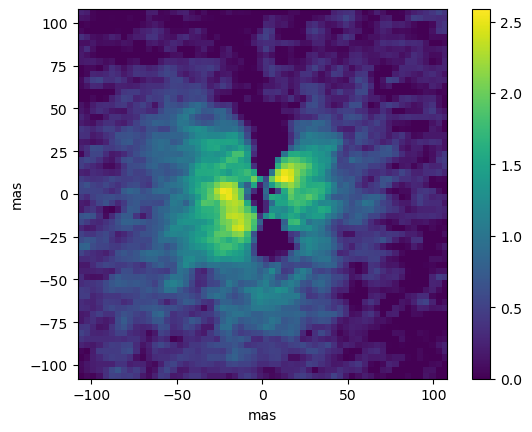

V709_Car_I_Q_phi_corr_tel+unres.fits
0.04572008858946903
V709_Car_I_PI_corr_tel+unres.fits
0.046302497


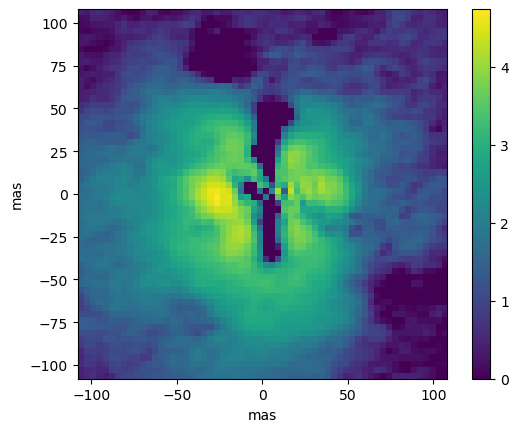

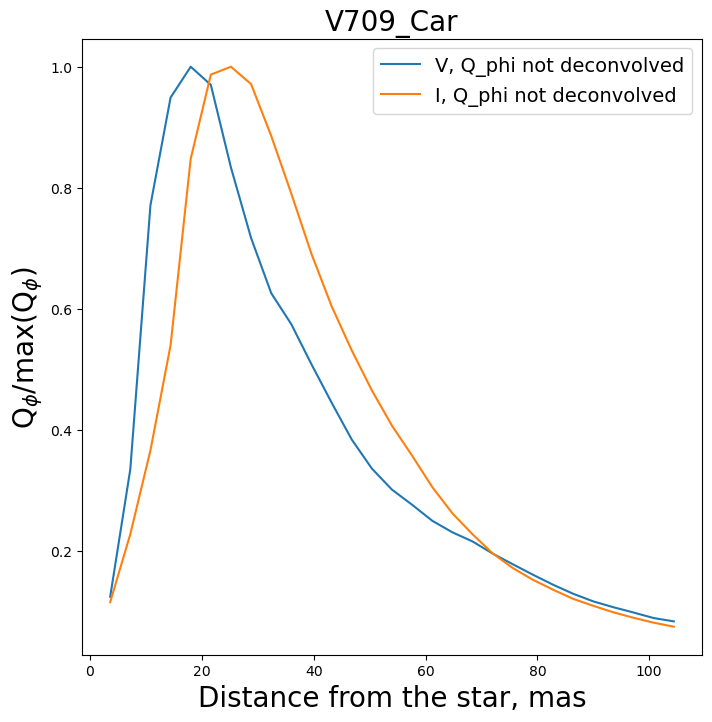

In [4]:

dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/After_deconv/'+star+'/'
dirdatI='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/'
figfolder=dirdat0
#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
xc=511.5
yc=511.5

for fittype in fittypes:
    
    I=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])  
    
    Q_phi, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    Q_phi, n=Loadimages_notdeconv(star,'Q_phi',dirdatI,band[int(fittype)-1],'_corr_tel+unres')
    PI, n=Loadimages_notdeconv(star,'PI',dirdatI,band[int(fittype)-1],'_corr_tel+unres')
        
    mask=(R<=1500/ps)
    #PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)

    I_mean_ar=[]
    #PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Q_phi_mean_ar=[]
    Q_phi_unres_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_I=I[mask]
        image_PI=PI[mask]
        #image_PSF=PSF[mask]
        image_Q_phi=Q_phi[mask]
        
        i_r_stop=i_r
        I_mean=np.mean(image_I)
        #PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        #PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
       
        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')


    if fittype=='1':
        print('V')
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar
        
    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar
        

    plotImage(Q_phi,30)
    plt.show()
    plt.close()
        
i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')

#plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
#plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')

plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi not deconvolved')
plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi not deconvolved')
plt.title(star,fontsize=20)
plt.legend(fontsize=14)
plt.savefig(figfolder+'radial_prof_not_deconv.png',bbox_inches='tight', pad_inches=0.1)
        
plt.show()
plt.close()

### Not deconvolved + PSF smearing

V709_Car_V_Q_phi_corr_smearing_tel+unres+PSF_smear.fits
0.023320166425712205
V709_Car_V_PI_corr_smearing_tel+unres+PSF_smear.fits
0.0235038623213768
V


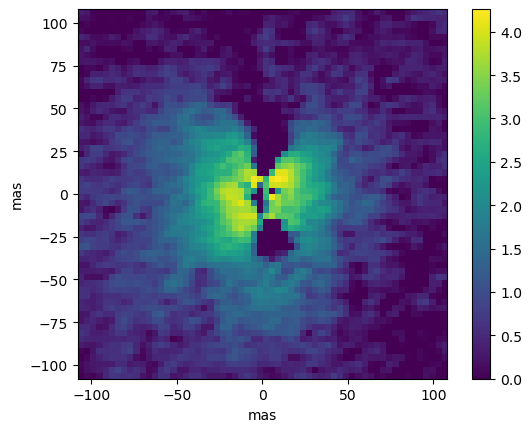

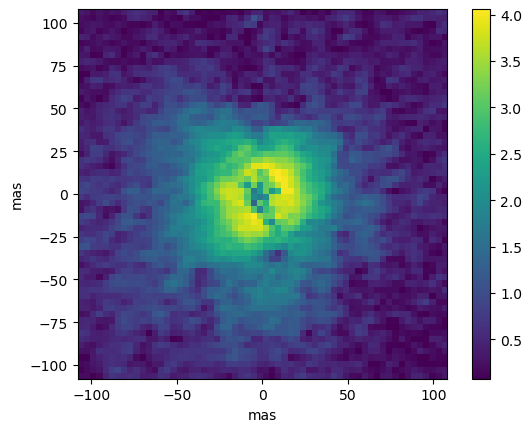

V709_Car_I_Q_phi_corr_smearing_tel+unres+PSF_smear.fits
0.04572008858946903
V709_Car_I_PI_corr_smearing_tel+unres+PSF_smear.fits
0.04630249738693237


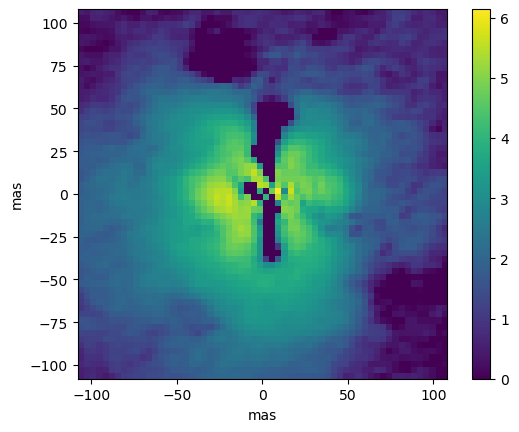

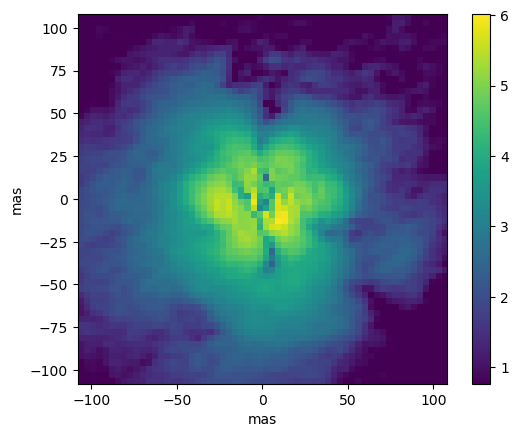

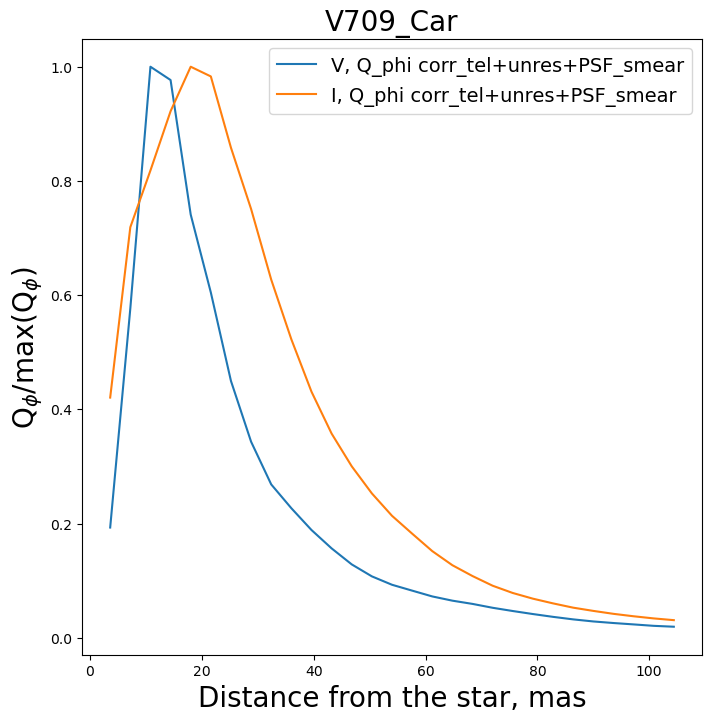

In [5]:

for fittype in fittypes:
    
    I=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    #PSF,n= Loadimagespsf('HD83878','/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/HD83878/mean_combined/',band[int(fittype)-1])  
    
    Q_phi, n=Loadimages_notdeconv(star,'Q_phi',dirdatI,band[int(fittype)-1],'_corr_smearing_tel+unres+PSF_smear')
    PI, n=Loadimages_notdeconv(star,'PI',dirdatI,band[int(fittype)-1],'_corr_smearing_tel+unres+PSF_smear')
    #f_q= LoadImage('/media/kateryna/Data_Lin/PhD/Analysis and results for SPHERE_stage_2/models/psf_smearing_HD83878/',band[int(fittype)-1]+'band_qphi_ellipse_pa121_i23_f_psf_50.fits')
    #f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/Analysis and results for SPHERE_stage_2/models/psf_smearing_HD83878/',band[int(fittype)-1]+'band_pi_ellipse_pa121_i23_f_psf_50.fits')
     
    #Q_phi=np.divide(Q_phi,f_q,where=f_q!=0)    
        
    mask=(R<=1500/ps)
    #PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)

    I_mean_ar=[]
    #PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Q_phi_mean_ar=[]
    Q_phi_unres_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_I=I[mask]
        image_PI=PI[mask]
        #image_PSF=PSF[mask]
        image_Q_phi=Q_phi[mask]
        
        i_r_stop=i_r
        I_mean=np.mean(image_I)
        #PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        #PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
       
        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')


    if fittype=='1':
        print('V')
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar
        
    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar
      
    plotImage(Q_phi,30)
    plt.show()
    plt.close()
    plotImage(PI,30)
    plt.show()
    plt.close()
    
i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')


#plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
#plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')

plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi corr_tel+unres+PSF_smear')
#plt.plot(i_rad,PI_mean_ar_V, label='V, PI corr_tel+unres+PSF_smear')

plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi corr_tel+unres+PSF_smear')
#plt.plot(i_rad,PI_mean_ar_I, label='I, PI corr_tel+unres+PSF_smear')
plt.title(star,fontsize=20)
plt.legend(fontsize=14)
plt.savefig(figfolder+'radial_prof_not_deconv+PSF.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()



### PSF Smearing coefficients

1024
V
1024


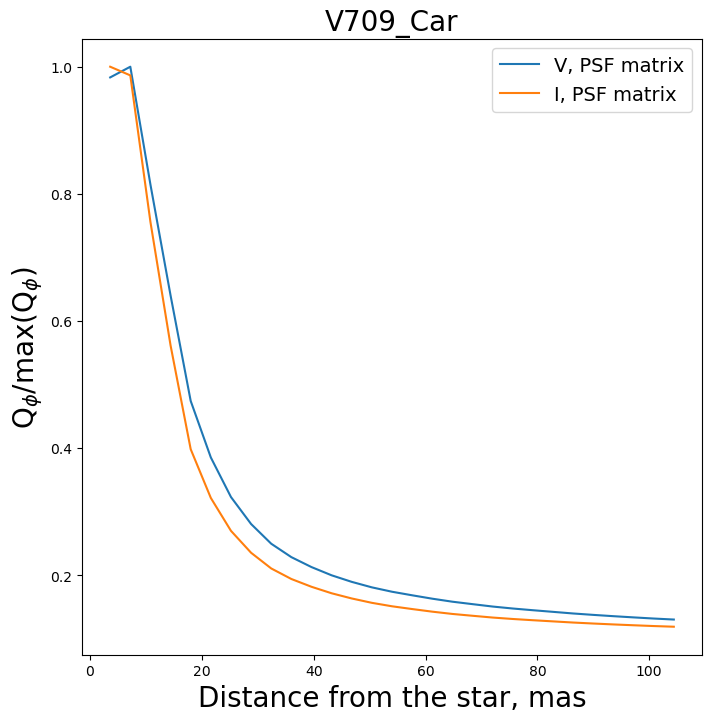

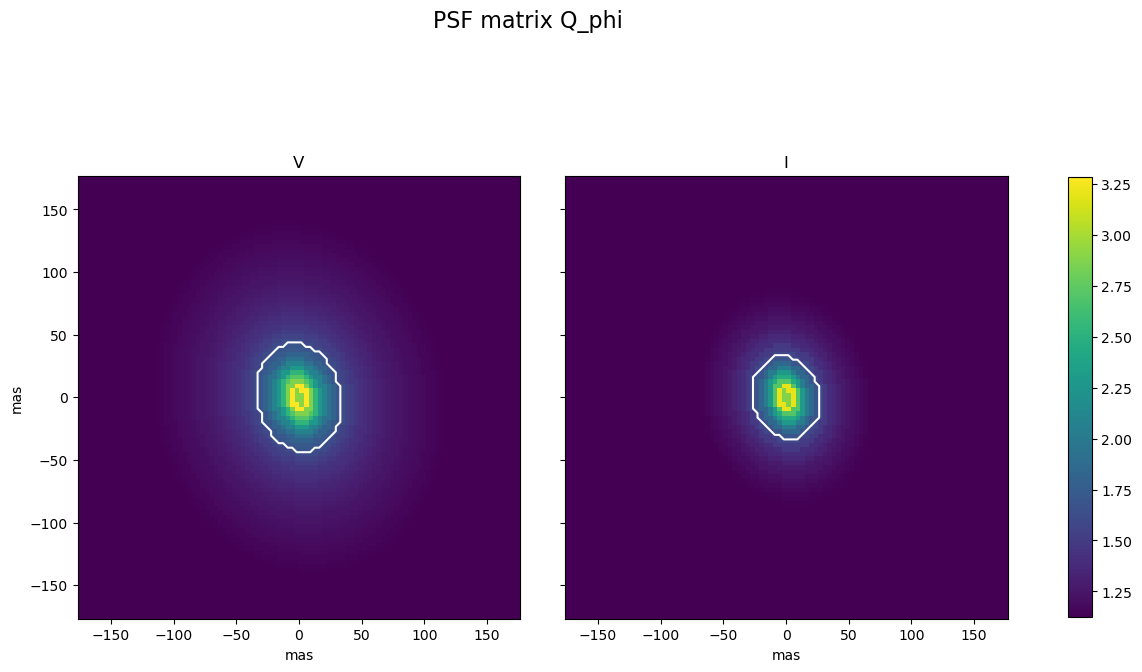

In [6]:

for fittype in fittypes:
    
    if star!='AR_Pup_dc_notnorm':
        f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
        f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
    elif star=='AR_Pup_dc_notnorm':
        f_q= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_qphi_circular_f_psf_50.fits')
        f_pi= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_pi_circular_f_psf_50.fits')
    Q_phi=f_q
    PI=f_pi
    PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])  
    
    mask=(R<=1500/ps)
    #PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)

    
    PI_mean_ar=[]
    Q_phi_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_PI=PI[mask]
        image_Q_phi=Q_phi[mask]
        
        i_r_stop=i_r
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
       
        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')


    if fittype=='1':
        print('V')
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar
        
    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar
        
i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')

#plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
#plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')

plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, PSF matrix')
plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, PSF matrix')
plt.title(star,fontsize=20)
plt.legend(fontsize=14)
plt.savefig(figfolder+'radial_prof_PSF.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

if star!='AR_Pup_dc_notnorm':
    f_qV= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+'V'+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
    f_qI= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+'I'+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
    
elif star=='AR_Pup_dc_notnorm':
    f_qV= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',"V"+'band_qphi_circular_f_psf_50.fits')
    f_qI= LoadImage('/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/PSF_models/'+ref_of_sci[star]+'/',"I"+'band_qphi_circular_f_psf_50.fits')
        
#f_qV= LoadImage('/media/kateryna/Data_Lin/PhD/Analysis and results for SPHERE_stage_2/models/psf_smearing_HD83878/','V'+'band_qphi_ellipse_pa121_i23_f_psf_50.fits')
#f_qI= LoadImage('/media/kateryna/Data_Lin/PhD/Analysis and results for SPHERE_stage_2/models/psf_smearing_HD83878/','I'+'band_qphi_ellipse_pa121_i23_f_psf_50.fits')
        


keys=['V','I']
labels={'V':'V','I':'I'}
data={'V': f_qV ,'I':f_qI}
cameras=['ZIMPOL','ZIMPOL']
plot_with_same_color(data, keys, labels ,'Q_phi','PSF matrix',4*ps,True,cameras)
#plt.savefig(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


### Deconvolved (only)

1024
V


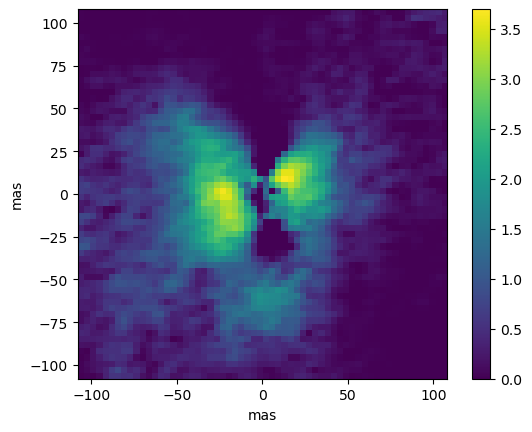

1024


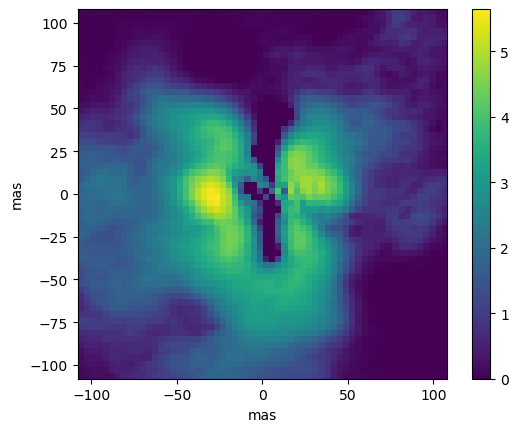

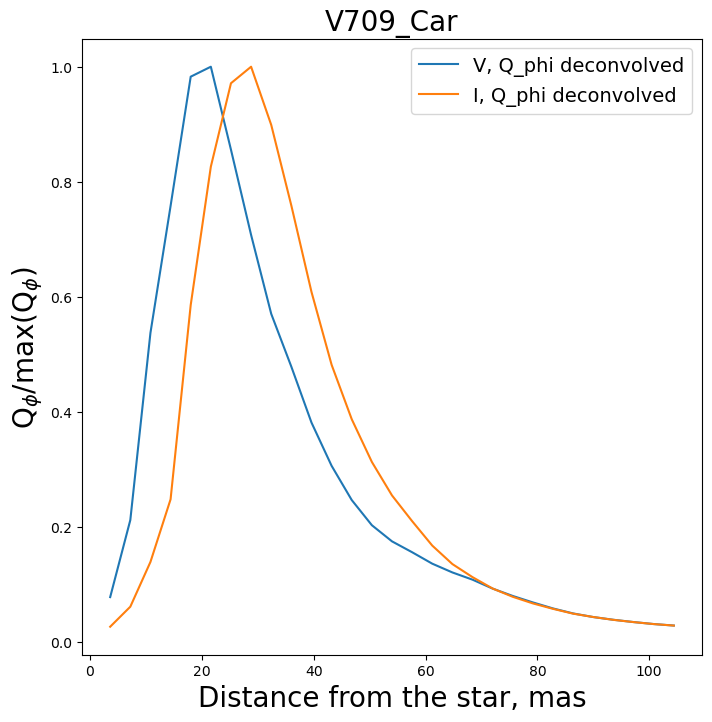

In [7]:

for fittype in fittypes:
    
    I=LoadImage(dirdatI,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])  
    dir =dirdat +'/deconvolved_'+'Q_phi'+'/' 
    Q_phi, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
    dir =dirdat +'/deconvolved_'+'PI'+'/'
    PI, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        
    mask=(R<=1500/ps)
    PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)

    I_mean_ar=[]
    PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Q_phi_mean_ar=[]
    Q_phi_unres_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_I=I[mask]
        image_PI=PI[mask]
        image_PSF=PSF[mask]
        image_Q_phi=Q_phi[mask]
        
        i_r_stop=i_r
        I_mean=np.mean(image_I)
        PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
       
        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')

    if fittype=='1':
        print('V')
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar
        
    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar
    
    plotImage(Q_phi,30)
    plt.show()
    plt.close()  

i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')


#plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
#plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')

plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi deconvolved')
#plt.plot(i_rad,PI_mean_ar_V, label='V, PI deconvolved')

plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi deconvolved')


plt.title(star,fontsize=20)
#plt.plot(i_rad,PI_mean_ar_I, label='I, PI deconvolved')
plt.legend(fontsize=14)
plt.savefig(figfolder+'radial_prof_deconv.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


### Deconvolved+PSF smearing

1024
V


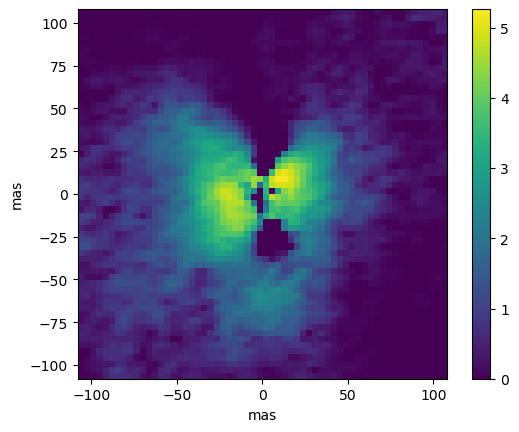

1024


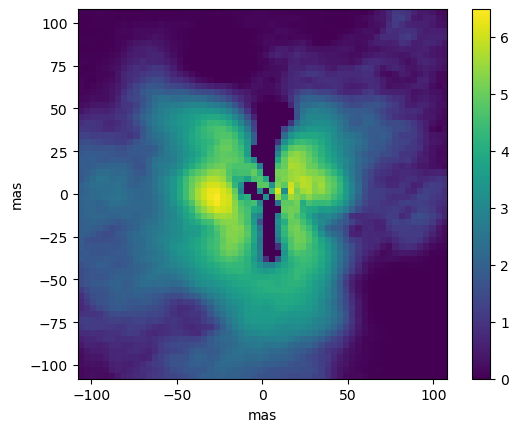

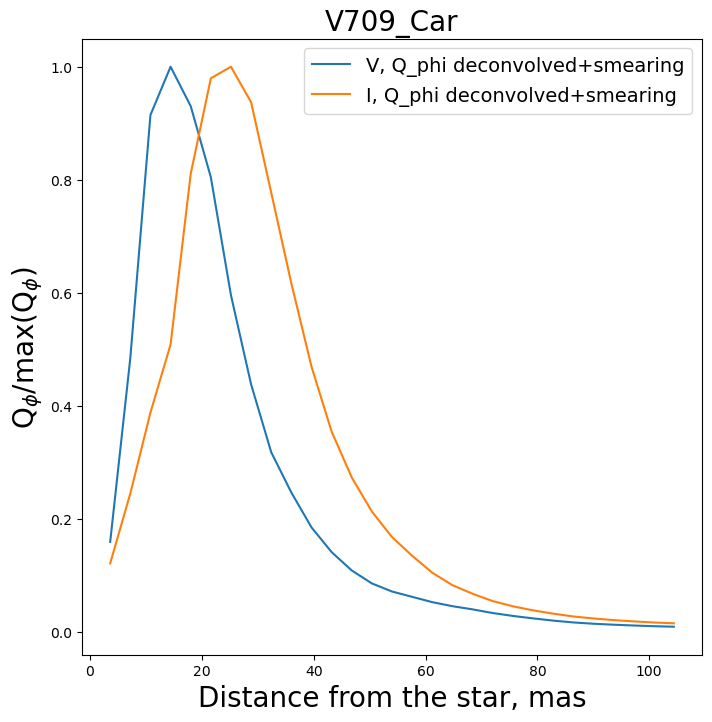

In [8]:

dirdat='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/'

for fittype in fittypes:
    
    I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])  
    PI, n=Loadimages(dirdat0,band[int(fittype)-1],'band_pi_decon+PSF_smear')
    Q_phi, n=Loadimages(dirdat0,band[int(fittype)-1],'band_qphi_decon+PSF_smear')
    
        
    mask=(R<=1500/ps)
    PSF=PSF#/np.max(PSF[mask])#*np.sum(PSF[mask])/10e6
    norm=np.max(I[mask])
    
    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)

    I_mean_ar=[]
    PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Q_phi_mean_ar=[]
    Q_phi_unres_mean_ar=[]
    for i_r in range (1,30,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))
        image_I=I[mask]
        image_PI=PI[mask]
        image_PSF=PSF[mask]
        image_Q_phi=Q_phi[mask]
        
        i_r_stop=i_r
        I_mean=np.mean(image_I)
        PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
       
        Q_phi_mean=np.mean(image_Q_phi)
        Q_phi_mean_ar.append(Q_phi_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')


    if fittype=='1':
        print('V')
        Q_phi_mean_ar_V=Q_phi_mean_ar
        PI_mean_ar_V=PI_mean_ar
        
    if fittype=='2':
        Q_phi_mean_ar_I=Q_phi_mean_ar
        PI_mean_ar_I=PI_mean_ar
        
    plotImage(Q_phi,30)
    plt.show()
    plt.close()   
    
i_rad=[float(x)*ps for x in range (1,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=20)
plt.xlabel('Distance from the star, mas', fontsize=20)
#plt.yscale('log')


#plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi unresolved corrected')
#plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi unresolved corrected')

plt.plot(i_rad,Q_phi_mean_ar_V/np.max(Q_phi_mean_ar_V), label='V, Q_phi deconvolved+smearing')
plt.plot(i_rad,Q_phi_mean_ar_I/np.max(Q_phi_mean_ar_I), label='I, Q_phi deconvolved+smearing')


#plt.plot(i_rad,PI_mean_ar_V, label='V, PI deconvolved+smearing')
#plt.plot(i_rad,PI_mean_ar_I, label='I, PI deconvolved+smearing')
plt.title(star,fontsize=20)
plt.legend(fontsize=14)
plt.savefig(figfolder+'radial_prof_deconv_PSF.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()


## Attempt to get percentage of scattered light using reference PSF



1024
V709_Car_V_Q_phi_corr_smearing_tel+unres+PSF_smear.fits
0.023320166425712205


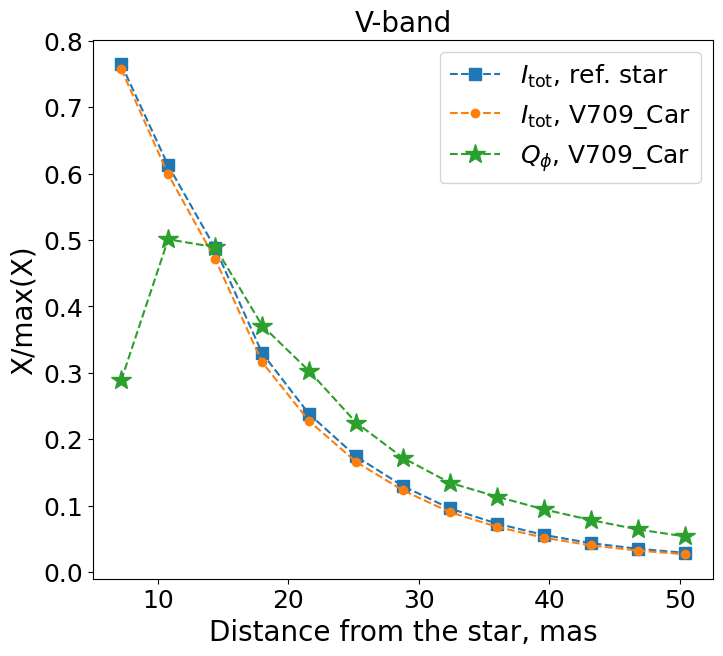

for pixel to pixel I-PSF  % 0.06236638605697621
1024
V709_Car_I_Q_phi_corr_smearing_tel+unres+PSF_smear.fits
0.04572008858946903


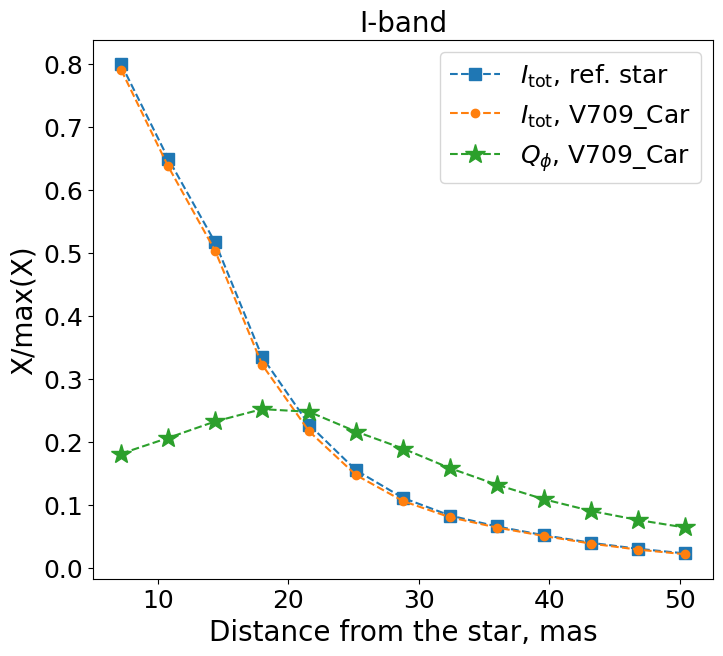

for pixel to pixel I-PSF  % 0.15760314527975255


In [9]:

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n

def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = '*'+band+'_'+fittype+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]
                
    return image, n



def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots(figsize=(8,6))
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas',fontsize=18)
    plt.ylabel("mas",fontsize=18)
    plt.colorbar()
    
    
    
import functions as f


dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/After_deconv/'

dirdat='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/'
figfolder='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'scattered/'
createfolder(figfolder)
figfolder=figfolder+star+'/'
createfolder(figfolder)


#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
xc=511.5
yc=511.5

for fittype in fittypes:
    
    I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])  
    PI_unres, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_'+'tel+unres')
    PI=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
    Qphi, n=Loadimages_notdeconv(star,'Q_phi',dirdatI,band[int(fittype)-1],'_corr_smearing_tel+unres+PSF_smear') 
    
    mask=(R<=500/ps)
    PSF=PSF#$/np.sum(PSF[mask])*10e6
    #print(np.max(I[mask]))
    #print(np.max(PI[mask]))
    
    
    norm=np.max(PI[mask])
    #PSF=PSF*norm
    
    I=I/np.max(I[mask])
    PSF=PSF/np.max(PSF[mask])
    #I=I/norm
    PI=PI/norm
    Qphi=Qphi/np.max(Qphi)
    #PI_unres=PI_unres/norm

    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)
    r, pos_angle = f.cart2polar_for_mask_defining(Xr, Yr)
    pos_angle=np.rad2deg(pos_angle)+180
    

    I_mean_ar=[]
    PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Qphi_mean_ar=[]
    for i_r in range (2,15,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))# & (pos_angle>startang)& (pos_angle<endang)
        image_I=I[mask]
        image_PI=PI[mask]
        image_PSF=PSF[mask]
        image_PI_unres=PI_unres[mask]
        image_Qphi=Qphi[mask]
        

        i_r_stop=i_r
        I_mean=np.mean(image_I)
        PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
        PI_unres_mean=np.mean(image_PI_unres)
        PI_unres_mean_ar.append(PI_unres_mean)
        Qphi_mean=np.mean(image_Qphi)
        Qphi_mean_ar.append(Qphi_mean)




    i_rad=[float(x)*ps for x in range (2,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

    fig, (ax1) = plt.subplots(1, 1,figsize=(8,7))
    plt.errorbar(i_rad,PSF_mean_ar, label=r'$I_{\rm tot}$, ref. star',fmt='--s', markersize=8)
    plt.errorbar(i_rad,I_mean_ar, label=r'$I_{\rm tot}$, '+star, fmt='--o')
    #plt.errorbar(i_rad,PI_mean_ar, label='PI, IRAS08544-4431', fmt='--o')
    plt.errorbar(i_rad,Qphi_mean_ar, label=r'$Q_{\phi}$, '+star, fmt='--*', markersize=15)
    plt.ylabel(r'X/max(X)', fontsize=20)
    plt.xlabel('Distance from the star, mas', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(band[int(fittype)-1]+'-band',fontsize=20)
    plt.legend(fontsize=18)
    #plt.yscale('log')

    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_scattered.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
   
    scattered=I-PSF
    scattered_pos=scattered*(scattered>=0)+1e-15*(scattered<0)



    Iscat_full=np.sum(scattered_pos*(R<=i_r))/np.sum(I*(R<=1500/ps))
    print('for pixel to pixel I-PSF  %',Iscat_full*100)


## to check difference between PI and Qphi



1024
V709_Car_V_Q_phi_corr_smearing_tel+unres+PSF_smear.fits
0.023320166425712205


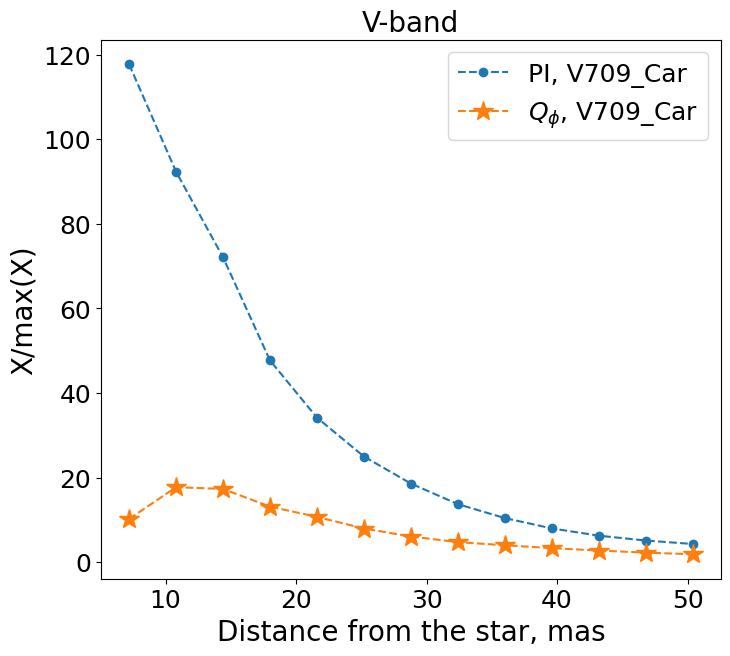

1024
V709_Car_I_Q_phi_corr_smearing_tel+unres+PSF_smear.fits
0.04572008858946903


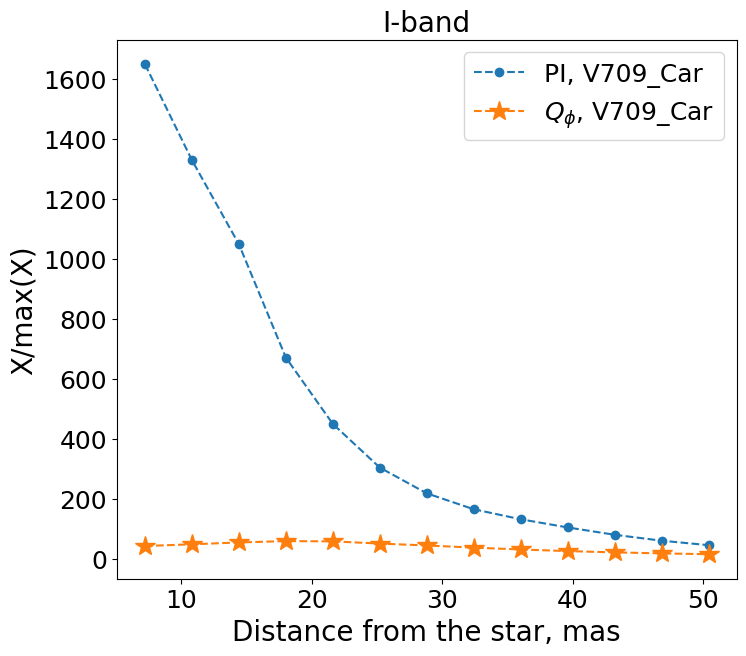

In [10]:

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n

def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = '*'+band+'_'+fittype+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]
                
    return image, n



def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots(figsize=(8,6))
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas',fontsize=18)
    plt.ylabel("mas",fontsize=18)
    plt.colorbar()
    
    
    
import functions as f


dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/After_deconv/'+star+'/'

dirdat='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/'
figfolder='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'scattered/'
createfolder(figfolder)
figfolder=figfolder+star+'/'
createfolder(figfolder)


#dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
xc=511.5
yc=511.5

for fittype in fittypes:
    
    I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
    PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])  
    PI_unres, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_'+'tel+unres')
    PI=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
    Qphi, n=Loadimages_notdeconv(star,'Q_phi',dirdatI,band[int(fittype)-1],'_corr_smearing_tel+unres+PSF_smear') 
    
    mask=(R<=500/ps)
    PSF=PSF#$/np.sum(PSF[mask])*10e6
    #print(np.max(I[mask]))
    #print(np.max(PI[mask]))
    
    
    norm=np.max(PI[mask])
    #PSF=PSF*norm
    
    I=I/np.max(I[mask])
    PSF=PSF/np.max(PSF[mask])
    #I=I/norm
    #PI=PI/norm
    #Qphi=Qphi/np.max(Qphi)
    #PI_unres=PI_unres/norm

    #radial_brightness

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R=np.sqrt(Xr**2 + (Yr)**2)
    r, pos_angle = f.cart2polar_for_mask_defining(Xr, Yr)
    pos_angle=np.rad2deg(pos_angle)+180
    

    I_mean_ar=[]
    PSF_mean_ar=[]
    PI_mean_ar=[]
    PI_unres_mean_ar=[]
    Qphi_mean_ar=[]
    for i_r in range (2,15,1):

        width=math.sqrt(i_r)/2
        mask = (R < i_r+width) & (R >=(i_r-width))# & (pos_angle>startang)& (pos_angle<endang)
        image_I=I[mask]
        image_PI=PI[mask]
        image_PSF=PSF[mask]
        image_PI_unres=PI_unres[mask]
        image_Qphi=Qphi[mask]
        

        i_r_stop=i_r
        I_mean=np.mean(image_I)
        PSF_mean=np.mean(image_PSF)
        I_mean_ar.append(I_mean)
        PSF_mean_ar.append(PSF_mean)
        PI_mean=np.mean(image_PI)
        PI_mean_ar.append(PI_mean)
        PI_unres_mean=np.mean(image_PI_unres)
        PI_unres_mean_ar.append(PI_unres_mean)
        Qphi_mean=np.mean(image_Qphi)
        Qphi_mean_ar.append(Qphi_mean)




    i_rad=[float(x)*ps for x in range (2,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

    fig, (ax1) = plt.subplots(1, 1,figsize=(8,7))
    plt.errorbar(i_rad,PI_mean_ar, label='PI, '+star, fmt='--o')
    plt.errorbar(i_rad,Qphi_mean_ar, label=r'$Q_{\phi}$, '+star, fmt='--*', markersize=15)
    plt.ylabel(r'X/max(X)', fontsize=20)
    plt.xlabel('Distance from the star, mas', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(band[int(fittype)-1]+'-band',fontsize=20)
    plt.legend(fontsize=18)
    #plt.yscale('log')

    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_PI_Qphi.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
   
    